In [1]:
import pymc as pm
import numpy as np
import arviz as az
import pandas as pd
import pytensor.tensor as pt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [4]:
import pandas as pd
import numpy as np
import pymc as pm

df = pd.read_csv('master_df.csv')

# Ensure numeric types and handle invalid entries
df['alpha'] = pd.to_numeric(df['alpha'], errors='coerce')
df['beta'] = pd.to_numeric(df['beta'], errors='coerce')
df['gamma'] = pd.to_numeric(df['gamma'], errors='coerce')
df['X'] = pd.to_numeric(df['X'], errors='coerce')

# Filter to keep only valid rows
df_clean = df[np.isfinite(df['alpha']) & np.isfinite(df['beta']) & np.isfinite(df['gamma']) & np.isfinite(df['X'])].copy()
df_clean = df_clean.reset_index(drop=True)

# Clip to avoid instability in model
alpha_data = np.clip(df_clean['alpha'].astype(float).values, 1e-6, None)
beta_data = np.clip(df_clean['beta'].astype(float).values, 1e-6, None)
gamma_data = np.clip(df_clean['gamma'].astype(float).values, 0.2, 5)  # Trimmed range
X_data = df_clean['X'].astype(int).values

# Build PyMC model
with pm.Model() as model:
    # Priors
    r1 = pm.Uniform('r1', lower=-1, upper=4)
    r2 = pm.Uniform('r2', lower=-4, upper=4)
    r3 = pm.Uniform('r3', lower=-1, upper=4)
    delta = pm.Uniform('delta', lower=0, upper=4)
    log_m = pm.Normal("log_m", mu=2.5, sigma=1.0)
    m = pm.Deterministic("m", pm.math.minimum(pm.math.exp(log_m), 50.0))

    # Relative strength calculation
    lambda_ = alpha_data**r1 * beta_data**r2 * gamma_data**r3
    lambda_delta = lambda_ * delta

    # Beta shape parameters
    a = m * lambda_delta
    b = m

    # Win probability
    p_s = pm.Beta('p_s', alpha=a, beta=b, shape=len(X_data))

    # Likelihood
    X_obs = pm.Bernoulli('X_obs', p=p_s, observed=X_data)

    # Inference
    trace = pm.sample(draws=2000, tune=1000, target_accept=0.95, cores=4, random_seed=42)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [r1, r2, r3, delta, log_m, p_s]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 45 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


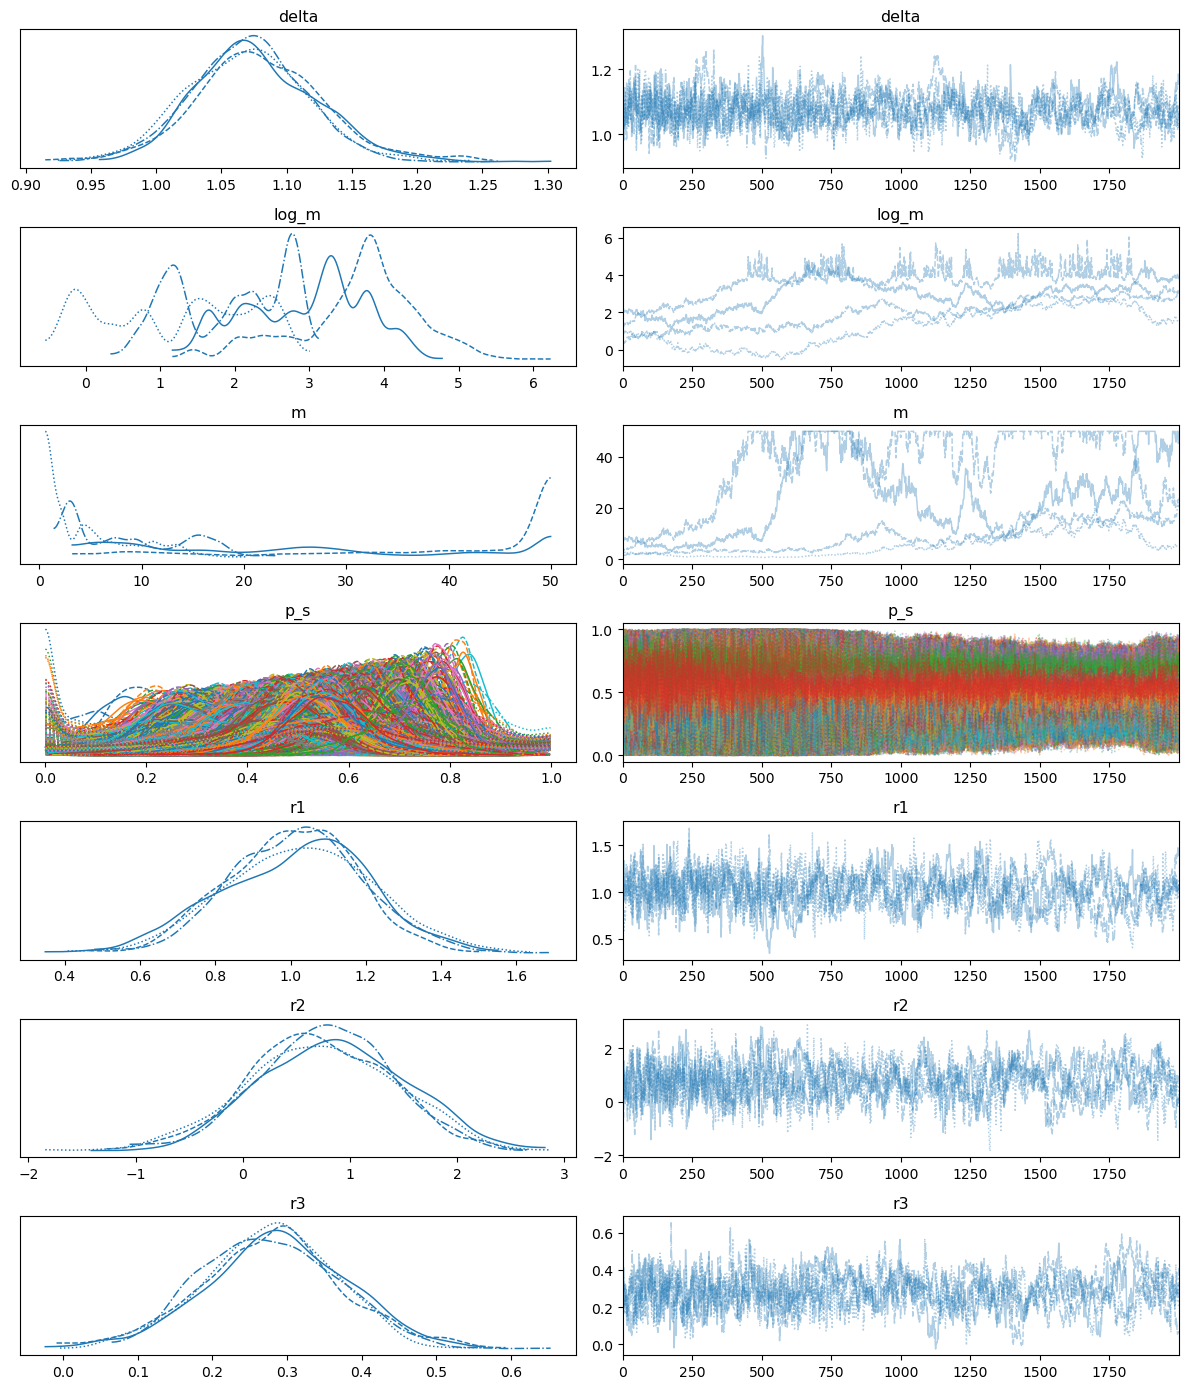

In [ ]:
import arviz as az
import matplotlib.pyplot as plt

# Plot trace for all parameters
az.plot_trace(trace)
plt.tight_layout()
plt.show()

In [5]:
def get_posterior_win_prob(trace, alpha_s, beta_s, gamma_s):
    # Extract 1D arrays from posterior
    def extract(var):
        return trace.posterior[var].stack(sample=("chain", "draw")).values  # shape (n_samples,)

    r1_samples = extract("r1")
    r2_samples = extract("r2")
    r3_samples = extract("r3")
    delta_samples = extract("delta")
    m_samples = extract("m")

    # Ensure everything is 1D (flatten just in case)
    r1_samples = r1_samples.flatten()
    r2_samples = r2_samples.flatten()
    r3_samples = r3_samples.flatten()
    delta_samples = delta_samples.flatten()
    m_samples = m_samples.flatten()

    # Calculate lambda for each posterior sample
    lambda_s = (alpha_s ** r1_samples) * (beta_s ** r2_samples) * (gamma_s ** r3_samples)

    # Shape parameters for the Beta distribution
    a_params = m_samples * lambda_s * delta_samples
    b_params = m_samples

    # Ensure same shape
    assert a_params.shape == b_params.shape == lambda_s.shape

    # Sample win probabilities
    p_samples = np.random.beta(a_params, b_params)  # shape (n_samples,)
    return p_samples


NameError: name 'plt' is not defined

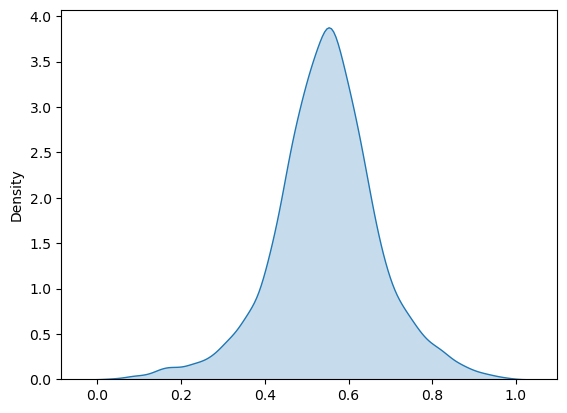

In [6]:
# === Example: pick game 0 from dataset ===
idx = 14
alpha_s = alpha_data[idx]
beta_s = beta_data[idx]
gamma_s = gamma_data[idx]
p_samples = get_posterior_win_prob(trace, alpha_s, beta_s, gamma_s)

# Plot posterior distribution of win probability
sns.kdeplot(p_samples, fill=True)
plt.title(f"Posterior Win Probability for Game {idx}")
plt.xlabel("Win Probability")
plt.ylabel("Density")
plt.show()

In [4]:
df = pd.read_csv('master_df.csv')
df.columns

Index(['gameId', 'startDate', 'homeTeam', 'awayTeam', 'homePitcher',
       'awayPitcher', 'homeScore', 'awayScore', 'betmgm_opening_homeOdds',
       'betmgm_opening_awayOdds', 'betmgm_current_homeOdds',
       'betmgm_current_awayOdds', 'fanduel_opening_homeOdds',
       'fanduel_opening_awayOdds', 'fanduel_current_homeOdds',
       'fanduel_current_awayOdds', 'caesars_opening_homeOdds',
       'caesars_opening_awayOdds', 'caesars_current_homeOdds',
       'caesars_current_awayOdds', 'bet365_opening_homeOdds',
       'bet365_opening_awayOdds', 'bet365_current_homeOdds',
       'bet365_current_awayOdds', 'draftkings_opening_homeOdds',
       'draftkings_opening_awayOdds', 'draftkings_current_homeOdds',
       'draftkings_current_awayOdds', 'homeTeam_abbr', 'awayTeam_abbr', 'year',
       'game_date', 'homeTeam_win_pct', 'awayTeam_win_pct',
       'homeTeam_batting_avg', 'awayTeam_batting_avg',
       'homePitcher_normalized', 'awayPitcher_normalized', 'game_year',
       'homePitcher_

In [12]:
opening_odds_columns = df.filter(like='opening').columns
opening_odds_df = df[opening_odds_columns]
opening_odds_df

,betmgm_opening_homeOdds,betmgm_opening_awayOdds,fanduel_opening_homeOdds,fanduel_opening_awayOdds,caesars_opening_homeOdds,caesars_opening_awayOdds,bet365_opening_homeOdds,bet365_opening_awayOdds,draftkings_opening_homeOdds,draftkings_opening_awayOdds
0,-190.0,155.0,-190.0,160.0,-179.0,160.0,-192.0,167.0,-170.0,150.0
1,-185.0,150.0,-190.0,160.0,-161.0,140.0,-170.0,150.0,-160.0,140.0
2,-225.0,180.0,-220.0,184.0,-222.0,190.0,-220.0,180.0,-155.0,135.0
3,-250.0,200.0,-250.0,205.0,-256.0,215.0,-260.0,215.0,-220.0,180.0
4,-105.0,-115.0,-102.0,-116.0,105.0,-125.0,105.0,-125.0,105.0,-125.0
...,...,...,...,...,...,...,...,...,...,...
2346,-210.0,170.0,-190.0,160.0,-196.0,162.0,-190.0,160.0,-205.0,170.0
2347,-135.0,110.0,-126.0,108.0,-130.0,110.0,-130.0,110.0,-130.0,110.0
2348,100.0,-120.0,-104.0,-112.0,100.0,-120.0,100.0,-120.0,102.0,-122.0
2349,-250.0,200.0,-270.0,220.0,-233.0,192.0,-230.0,190.0,-238.0,195.0


In [14]:
import pandas as pd

def american_to_implied_prob(odds):
    """Convert American odds to implied probability (with vig)."""
    return 100 / (odds + 100) if odds > 0 else -odds / (-odds + 100)

def add_fair_implied_probs(df):
    odds_columns = [
        'betmgm_opening_homeOdds', 'betmgm_opening_awayOdds',
        'fanduel_opening_homeOdds', 'fanduel_opening_awayOdds',
        'caesars_opening_homeOdds', 'caesars_opening_awayOdds',
        'bet365_opening_homeOdds', 'bet365_opening_awayOdds',
        'draftkings_opening_homeOdds', 'draftkings_opening_awayOdds'
    ]
    
    for i in range(0, len(odds_columns), 2):
        home_col = odds_columns[i]
        away_col = odds_columns[i+1]

        home_prob = df[home_col].apply(american_to_implied_prob)
        away_prob = df[away_col].apply(american_to_implied_prob)

        total_prob = home_prob + away_prob

        # Use .loc to avoid SettingWithCopyWarning
        df.loc[:, home_col.replace('Odds', 'FairProb')] = home_prob / total_prob
        df.loc[:, away_col.replace('Odds', 'FairProb')] = away_prob / total_prob

    return df

add_fair_implied_probs(opening_odds_df)

,betmgm_opening_homeOdds,betmgm_opening_awayOdds,fanduel_opening_homeOdds,fanduel_opening_awayOdds,caesars_opening_homeOdds,caesars_opening_awayOdds,bet365_opening_homeOdds,bet365_opening_awayOdds,draftkings_opening_homeOdds,draftkings_opening_awayOdds,betmgm_opening_homeFairProb,betmgm_opening_awayFairProb,fanduel_opening_homeFairProb,fanduel_opening_awayFairProb,caesars_opening_homeFairProb,caesars_opening_awayFairProb,bet365_opening_homeFairProb,bet365_opening_awayFairProb,draftkings_opening_homeFairProb,draftkings_opening_awayFairProb
0,-190.0,155.0,-190.0,160.0,-179.0,160.0,-192.0,167.0,-170.0,150.0,0.625565,0.374435,0.630102,0.369898,0.625202,0.374798,0.637105,0.362895,0.611511,0.388489
1,-185.0,150.0,-190.0,160.0,-161.0,140.0,-170.0,150.0,-160.0,140.0,0.618729,0.381271,0.630102,0.369898,0.596849,0.403151,0.611511,0.388489,0.596273,0.403727
2,-225.0,180.0,-220.0,184.0,-222.0,190.0,-220.0,180.0,-155.0,135.0,0.659686,0.340314,0.661304,0.338696,0.666598,0.333402,0.658120,0.341880,0.588212,0.411788
3,-250.0,200.0,-250.0,205.0,-256.0,215.0,-260.0,215.0,-220.0,180.0,0.681818,0.318182,0.685393,0.314607,0.693737,0.306263,0.694656,0.305344,0.658120,0.341880
4,-105.0,-115.0,-102.0,-116.0,105.0,-125.0,105.0,-125.0,105.0,-125.0,0.489166,0.510834,0.484603,0.515397,0.467532,0.532468,0.467532,0.532468,0.467532,0.532468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2346,-210.0,170.0,-190.0,160.0,-196.0,162.0,-190.0,160.0,-205.0,170.0,0.646522,0.353478,0.630102,0.369898,0.634351,0.365649,0.630102,0.369898,0.644729,0.355271
2347,-135.0,110.0,-126.0,108.0,-130.0,110.0,-130.0,110.0,-130.0,110.0,0.546770,0.453230,0.536961,0.463039,0.542744,0.457256,0.542744,0.457256,0.542744,0.457256
2348,100.0,-120.0,-104.0,-112.0,100.0,-120.0,100.0,-120.0,102.0,-122.0,0.478261,0.521739,0.491091,0.508909,0.478261,0.521739,0.478261,0.521739,0.473913,0.526087
2349,-250.0,200.0,-270.0,220.0,-233.0,192.0,-230.0,190.0,-238.0,195.0,0.681818,0.318182,0.700162,0.299838,0.671390,0.328610,0.669007,0.330993,0.675031,0.324969
